In [194]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

In [195]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

# Task 1. Algorithm's analysis

## Generating graph

In [196]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """


    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))

    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)

    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)

    if draw:
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue',
                    with_labels=True,
                    node_size=500,
                    arrowsize=20,
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)

        else:
            nx.draw(G, node_color='lightblue',
                with_labels=True,
                node_size=500)

    return G

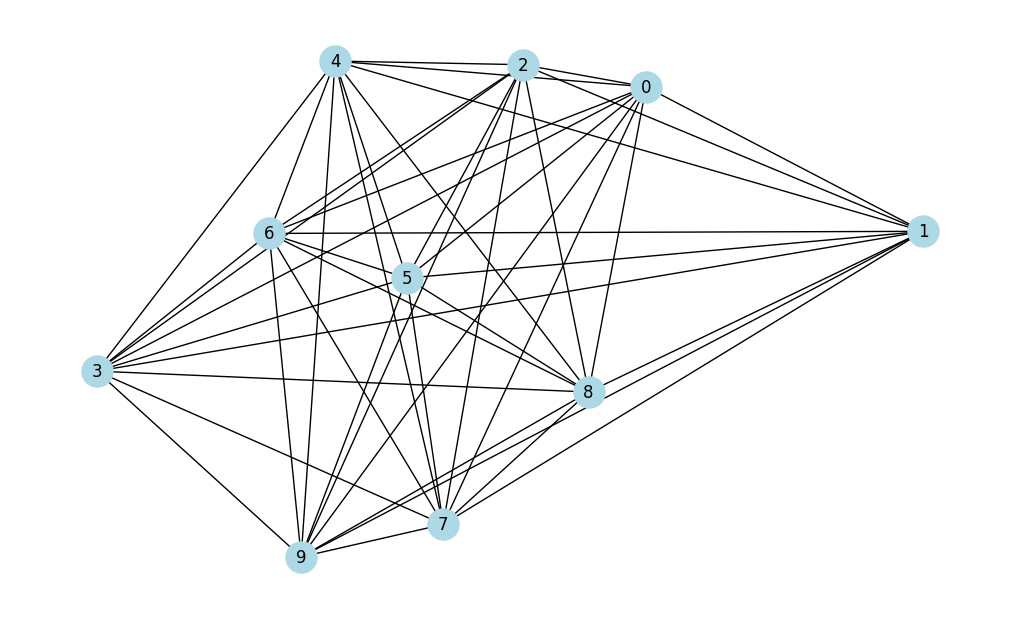

In [197]:
G = gnp_random_connected_graph(10, 1, False, True)

## Subtask 1.1

### Kruskal's algorithm

In [198]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

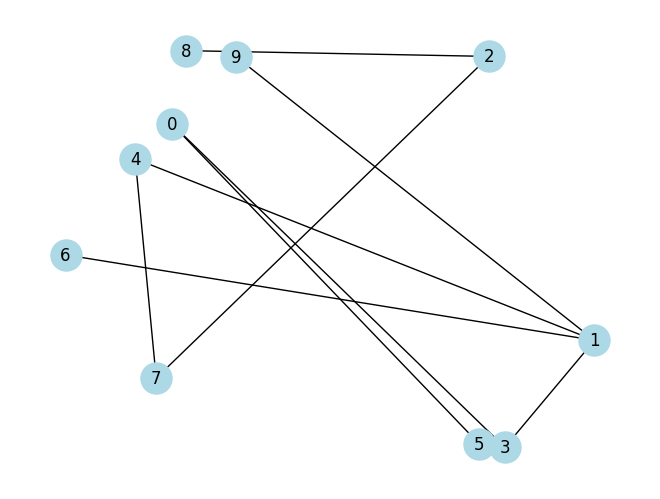

In [199]:
nx.draw(mstk, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [200]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 3), (0, 5), (1, 3), (1, 4), (1, 6), (1, 9), (2, 7), (2, 8), (4, 7)]),
 9)

**Алгоритм Крускала** — це жадібний алгоритм для знаходження мінімального кістякового дерева (MST) у зв’язному неорієнтованому графі з ваговими ребрами. Його основний принцип полягає у поступовому додаванні до кістякового дерева найдешевших ребер, які не утворюють циклу.     

Використовується рекурсія замість традиційної ітеративної реалізації з об'єднанням множин (Union-Find).

Видалення непотрібних ребер відбувається без явного використання структур даних, що може вплинути на ефективність при великій кількості вершин.

In [201]:
def kruskal_mst(G, nvn=None):
    if nvn is None:
        nodes = [[node] for node in G.nodes]
        edges = list(G.edges)
    else:
        nodes, edges = nvn

    min_ = (float("inf"), tuple())
    for a,b in edges:
        weight = G[a][b]['weight']
        if weight < min_[0]:
            min_ = (weight, (a,b))

    connecting_nodes = []
    for i, node in enumerate(nodes):
        if min_[1][0] in node or min_[1][1] in node:
            connecting_nodes.append(i)

    nodes[connecting_nodes[0]] += nodes[connecting_nodes[1]]

    del nodes[connecting_nodes[1]]

    node = nodes[connecting_nodes[0]]

    for edge in edges.copy():
        if edge[0] in node and edge[1] in node:
            edges.remove(edge)

    if len(nodes) == 1:
        return [min_[1]]
    else:
        return sorted([min_[1]] + kruskal_mst(G, (nodes, edges)))

kruskal_mst(G)

[(0, 3), (0, 5), (1, 3), (1, 4), (1, 6), (1, 9), (2, 7), (2, 8), (4, 7)]

### Prim's algorithm

In [202]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

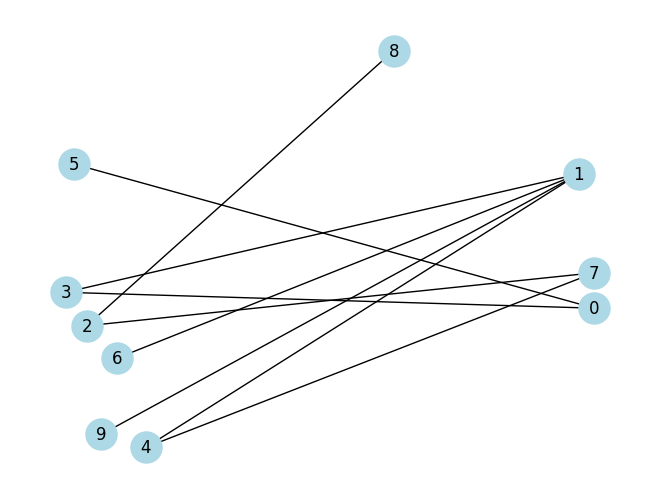

In [203]:
nx.draw(mstp, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [204]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 3), (0, 5), (1, 3), (1, 4), (1, 6), (1, 9), (2, 7), (2, 8), (4, 7)]),
 9)

#### Алгоритм Прима

Наведено приклад реалізації алгоритму Прима. Він дозволяє побудувати мінімальне кістякове дерево зваженого зв’язного неорієнтованого графа.

Алгоритм працює за таким принципом:

Нехай G – зв’язний зважений граф із nn вершинами та mm ребрами. Виконати такі дії:

1. Вибрати ребро e1​, яке має в графі G найменшу вагу.
2. Послідовно визначити ребра e2​,e3​,…,en−1​, на кожному кроці *обираючи ребро з найменшою вагою*, **інцидентне вершині побудованого дерева, таке, що не утворює простих циклів із уже вибраними ребрами**.

Отримане дерево T із множиною ребер E(T)={e1​,e2​,e3​,…,en−1​} є *мінімальним кістяковим деревом графа* G.

Реалізація алгоритму виводить пари вершин ребер у *форматі (v1​,v2​), де v1 і v2 – вершини графа* та утворюють мінімальне кістякове дерево. Вивід відсортовано в порядку зростання для зручності читання.

In [205]:
def prim_mst(G):
    start_node = list(G.nodes())[0]
    mst_edges = []
    visited = set([start_node])
    potential_edges = []

    for neighbor, info in G[start_node].items():
        potential_edges.append((info['weight'], start_node, neighbor))

    while potential_edges:
        potential_edges.sort(key=lambda x: x[0])

        weight, node_1, node_2 = potential_edges.pop(0)

        if node_2 not in visited:
            visited.add(node_2)
            mst_edges.append((node_1, node_2))
            for neighbor, info in G[node_2].items():
                if neighbor not in visited:
                    potential_edges.append((info['weight'], node_2, neighbor))

    return sorted(mst_edges)

print(prim_mst(G))

[(0, 3), (0, 5), (1, 4), (1, 6), (1, 9), (2, 8), (3, 1), (4, 7), (7, 2)]


## Subtask 1.2

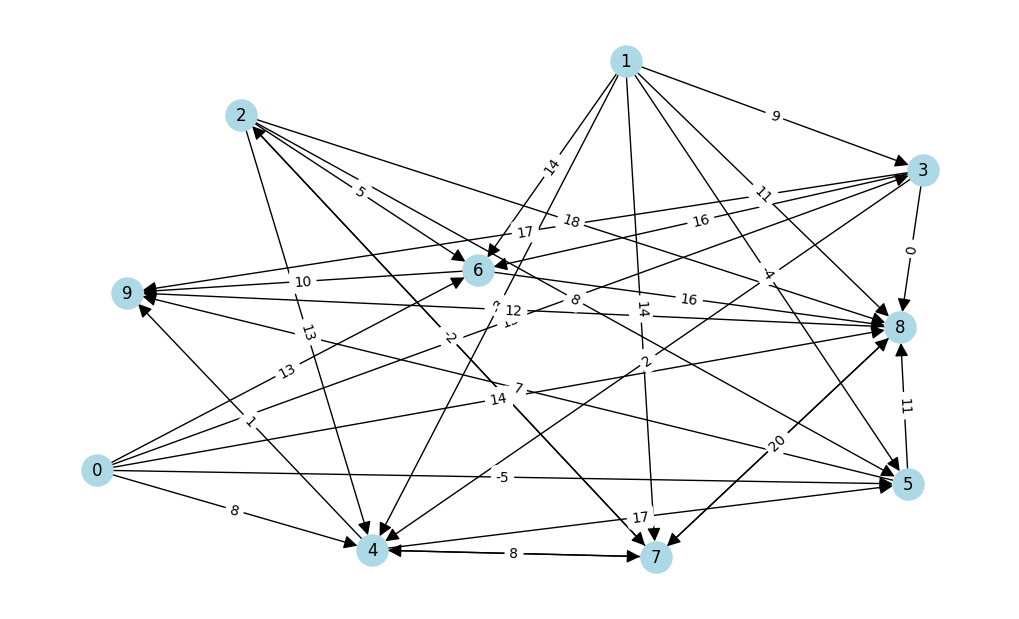

In [206]:
G = gnp_random_connected_graph(10, 0.5, True, True)

### Bellman-Ford algorithm

In [207]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Negative cycle detected


### Алгоритм Беллмана — Форда

Алгоритм Беллмана-Форда використовується для знаходження найкоротших шляхів від початкової вершини до всіх інших у зваженому орієнтованому графі. Він корисний у випадках, коли граф містить ребра з від’ємною вагою, що робить його більш гнучким у порівнянні з алгоритмом Дейкстри

Вивід:
Якщо граф не містить від’ємних циклів, повертається словник, де ключем є вершина, а значенням – мінімальна відстань від початкової вершини до цієї вершини.

In [208]:
def bellman_ford(G, start_node):
    distance = {node: float('inf') for node in G.nodes()}
    distance[start_node] = 0

    for _ in range(len(G.nodes()) - 1):
        for u in G.nodes():
            for v in G.neighbors(u):
                weight = G.get_edge_data(u, v).get('weight', float("inf"))
                if distance[u] + weight < distance[v]:
                    distance[v] = distance[u] + weight


    for u in G.nodes():
        for v in G.neighbors(u):
            weight = G.get_edge_data(u, v).get('weight', float("inf"))
            if distance[u] + weight < distance[v]:
                return "Negative cycle detected"

    return distance

print(bellman_ford(G, 0))

Negative cycle detected


### Floyd-Warshall algorithm

In [209]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G)
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

pred

Distances with 0 source: {0: 0, 5: -5, 3: 13, 4: 8, 6: 13, 8: 1, 1: inf, 2: 9, 7: 7, 9: 2}
Distances with 1 source: {1: 0, 5: -4, 3: 9, 4: -3, 6: 3, 7: -4, 8: -10, 0: inf, 2: -2, 9: -2}
Distances with 2 source: {2: -4, 4: 6, 5: 4, 6: 1, 7: -6, 8: -12, 0: inf, 1: inf, 3: inf, 9: 0}
Distances with 3 source: {3: 0, 6: 8, 4: 2, 8: -5, 9: 3, 0: inf, 1: inf, 2: 3, 5: 11, 7: 1}
Distances with 4 source: {4: 0, 5: 9, 7: -1, 9: 1, 0: inf, 1: inf, 2: 1, 3: inf, 6: 6, 8: -7}
Distances with 5 source: {5: 0, 9: 7, 8: 10, 0: inf, 1: inf, 2: 25, 3: inf, 4: 35, 6: 30, 7: 23}
Distances with 6 source: {6: 0, 8: 15, 9: 10, 0: inf, 1: inf, 2: 30, 3: inf, 4: 40, 5: 38, 7: 28}
Distances with 7 source: {7: -8, 2: -6, 4: 4, 8: -14, 0: inf, 1: inf, 3: inf, 5: 2, 6: -1, 9: -2}
Distances with 8 source: {8: -2, 7: 11, 9: 10, 0: inf, 1: inf, 2: 13, 3: inf, 4: 23, 5: 21, 6: 18}
Distances with 9 source: {9: 0, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 8: inf}


{0: {5: 0, 3: 0, 4: 0, 6: 0, 8: 7, 9: 5, 7: 2, 2: 7},
 1: {5: 1, 3: 1, 4: 1, 6: 2, 7: 2, 8: 7, 9: 4, 2: 7},
 2: {4: 7, 5: 2, 6: 2, 7: 2, 8: 7, 9: 8, 2: 7},
 3: {6: 2, 4: 3, 8: 7, 9: 4, 5: 2, 7: 2, 2: 7},
 4: {5: 2, 7: 2, 9: 4, 8: 7, 2: 7, 6: 2},
 5: {9: 5, 8: 7, 2: 7, 4: 7, 6: 2, 7: 2},
 6: {8: 7, 9: 6, 2: 7, 4: 7, 5: 2, 7: 2},
 7: {2: 7, 4: 7, 8: 7, 5: 2, 6: 2, 7: 2, 9: 8},
 8: {7: 2, 9: 8, 2: 7, 4: 7, 5: 2, 6: 2, 8: 7}}

Алгоритм Флойда-Воршалла — це алгоритм динамічного програмування, що використовується для знаходження найкоротших шляхів між усіма парами вершин у зваженому графі. Він підходить як для орієнтованих, так і для неорієнтованих графів і працює з від’ємними вагами ребер, але не підтримує від’ємні цикли.

Перевірка на від’ємні цикли

    Якщо на діагоналі dist[i][i] (Тобто відстань від вершини до самої себе) < 0, це означає наявність від’ємного циклу, що робить задачу пошуку шляхів некоректною.

Повернення результату

    pred — матриця попередників для відновлення шляхів.
    dist — матриця найкоротших відстаней між всіма парами вершин.

In [210]:
def floyd(G):
    nodes = list(G.nodes)
    pred = dict( [(node, dict([(node2, node)for node2 in G.nodes])) for node in G.nodes])

    dist = {}
    for node in nodes:
        dist[node] = {}
        for other_node in nodes:
            if node == other_node:
                dist[node][other_node] = 0
            elif G.has_edge(node, other_node):
                dist[node][other_node] = G[node][other_node]['weight']
            else:
                dist[node][other_node] = float('inf')

    for k in nodes:
        for i in nodes:
            for j in nodes:
                from_k = dist[i][k] + dist[k][j]
                if from_k < dist[i][j]:
                    dist[i][j] = from_k
                    pred[i][j] = k

    for i in nodes:
        if dist[i][i] < 0:
            return "negative cicle detected -_-"
    return pred, dist

floyd(G)

'negative cicle detected -_-'

---

## Some useful explanations
### How to get list of edges for your algorithm

In [211]:
edges = list(G.edges()) # by default G.edges are EdgesView class

In [212]:
edges[:5]

[(0, 5), (0, 3), (0, 4), (0, 6), (0, 8)]

### To get edges with weights

In [213]:
edges = list(G.edges(data=True))

In [214]:
edges[:5]

[(0, 5, {'weight': -5}),
 (0, 3, {'weight': 13}),
 (0, 4, {'weight': 8}),
 (0, 6, {'weight': 13}),
 (0, 8, {'weight': 14})]

In [215]:
nodes = list(G.nodes())
print(nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Example on time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [216]:
import time
from tqdm import tqdm

Допоміжна функція для вимірювання часу виконання алгоритму.

In [217]:
def measure(func, *args, **kwargs):
    start = time.time()
    func(*args, **kwargs)
    end = time.time()

    return end-start

Функція для побудови графіків ефективності різних алгоритмів 

In [218]:

def plot_graph(time_taken, title):
    plt.figure()
    plt.plot(time_taken['standard'].values(), time_taken['standard'].keys(), label="standard", color="b", linestyle="-")
    plt.plot(time_taken['reality'].values(), time_taken['reality'].keys(), label="reality", color="g", linestyle="-")
    plt.xlabel("time")
    plt.ylabel("count_of_nodes")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

Задання  кількості  ітерацій для перевірки алгоритмів. 

In [219]:
NUM_OF_ITERATIONS = 100

Вимірювання часу виконання алгоритму Прима.

100%|██████████| 100/100 [00:00<00:00, 5410.19it/s]


100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


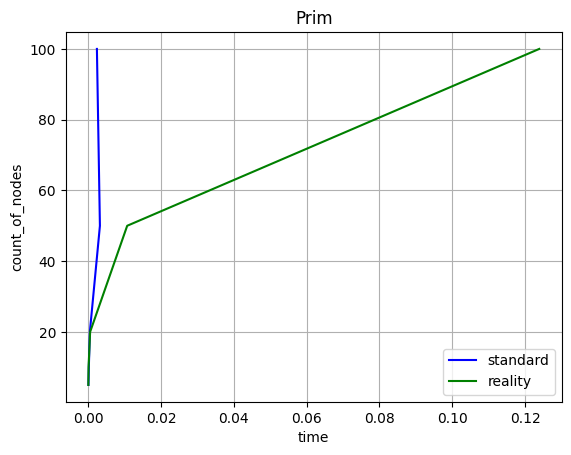

In [220]:
time_taken = {'standard':{}, 'reality': {}}

for count in (5, 10, 20, 50, 100):
    for _ in tqdm(range(NUM_OF_ITERATIONS)):
        G = gnp_random_connected_graph(count, 0.4, False)
        time_taken['standard'][count] = measure(tree.minimum_spanning_tree, G, algorithm="prim")
        time_taken['reality'][count] = measure(prim_mst, G)
plot_graph(time_taken, "Prim")

Вимірювання часу виконання алгоритму Крускала.

100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


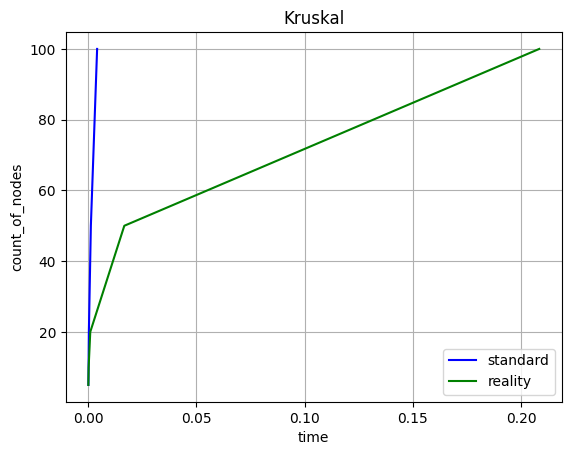

In [221]:
time_taken = {'standard':{}, 'reality': {}}

for count in (5, 10, 20, 50, 100):
    for _ in tqdm(range(NUM_OF_ITERATIONS)):
        G = gnp_random_connected_graph(count, 0.4, False)
        time_taken['standard'][count] = measure(tree.minimum_spanning_tree, G, algorithm="kruskal")
        time_taken['reality'][count] = measure(kruskal_mst, G)
plot_graph(time_taken, "Kruskal")

Вимірювання часу виконання алгоритму Беллмана-Форда.

100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


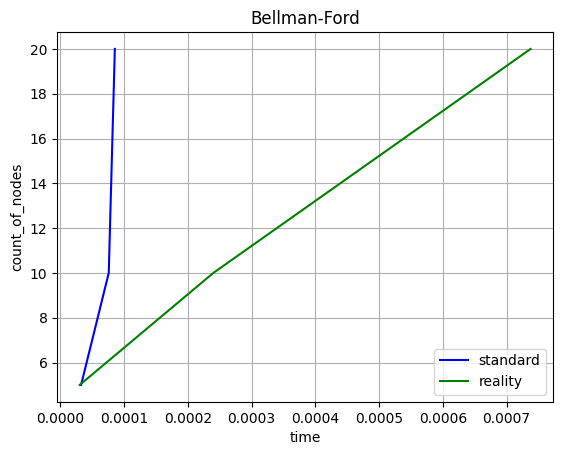

In [222]:

time_taken = {"standard": {}, "reality": {}}
for count in (5, 10, 20, 50, 100, 200):
    for _ in tqdm(range(NUM_OF_ITERATIONS)):
        G = gnp_random_connected_graph(count, 0.4, True)
        try:
            time_taken["standard"][count] = measure(bellman_ford_predecessor_and_distance, G, 0)
            time_taken["reality"][count] = measure(bellman_ford, G, 0)
        except:
            pass
plot_graph(time_taken, "Bellman-Ford")

Вимірювання часу виконання алгоритму Флойда—Воршелла. 

100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


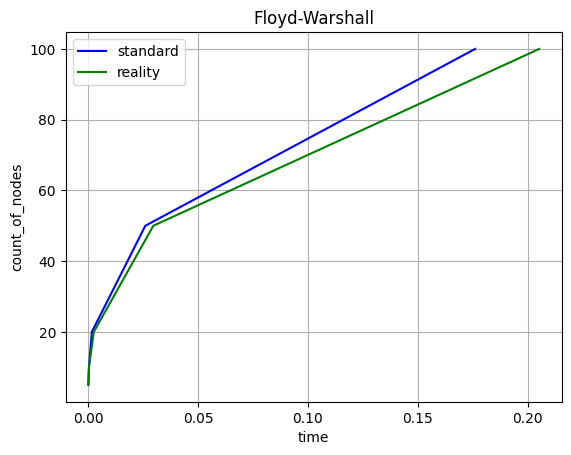

In [223]:
time_taken = {'standard':{}, 'reality': {}}

for count in (5, 10, 20, 50, 100):
    for _ in tqdm(range(NUM_OF_ITERATIONS)):
        G = gnp_random_connected_graph(count, 0.4, True)
        try:
            time_taken["standard"][count] = measure(floyd_warshall_predecessor_and_distance, G)
            time_taken["reality"][count] = measure(floyd, G)
        except:
            pass

plot_graph(time_taken, "Floyd-Warshall")


Реалізовані нами алгоритми як бачимо є значно повільніші. Імовірними причинами є те, що ми використовуємо в своїх реалізаціях лише вбудовані типи даних, а також використовуємо цикли замість рекурсії. А також можливо алгоритми реалізовані нами вирішують задачу більш очевидним способом

## Task 2. Decision Tree Classifier 

In [224]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### General idea

#### You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

#### Hopefully, you have already learned what is decision tree classifier and how it work. For better understanding, and in case if something is still unclear for you, here are some useful links on basics of DTC:
- https://www.youtube.com/watch?v=ZVR2Way4nwQ
- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
- https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775
- https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
- https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b6057

#### Also, for those interested to learn more about machine learning and particulary Desicion Trees - here is a great course on Coursera (you may be interested in the whole course or just this particular week):
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


### Dataset
#### You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. 
Read more on this: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
https://en.wikipedia.org/wiki/Iris_flower_data_set
#### However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.
P.S. In case you are not sure if your dataset is suitable, feel free to ask assistants :).

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [225]:
# Load dataset
iris = load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [226]:
iris.data.shape

(150, 4)

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [227]:
iris.data[0:2]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2]])

### To undestand data little bit better, let's plot some features

Text(0, 0.5, 'Sepal width')

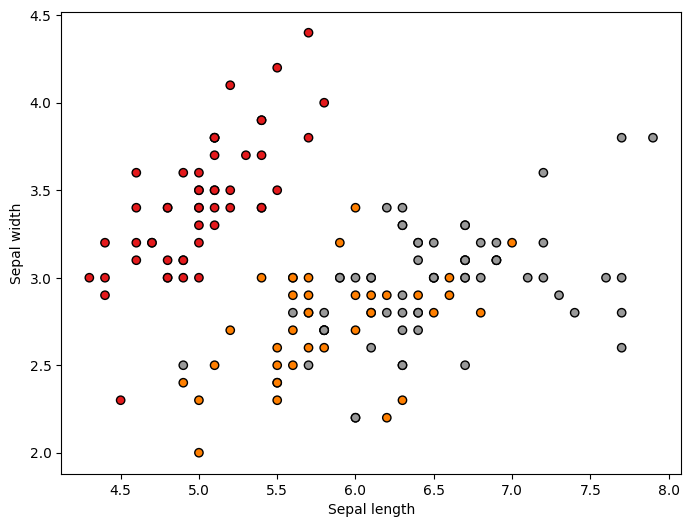

In [228]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage


**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [229]:
#clf = DecisionTreeClassifier()

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [230]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

((30, 4), (30,))

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [231]:
clf = clf.fit(X, y)

NameError: name 'clf' is not defined

### Visualization of produced tree

You do not need to understand this piece of code :)

In [ ]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("iris")

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,
                     feature_names=iris.feature_names,
                     class_names=iris.target_names,
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [ ]:
predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [ ]:
sum(predictions == y_test) / len(y_test)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [ ]:
y_test


Here you can traverse the tree above by yourself and make sure that prediction works

In [ ]:
X_test[1]

In [ ]:
clf.predict([X_test[1]])

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Finally, it is your turn to write such classifier by yourself!

####  Gini impurity

Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$

#### Remarks 
- We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.
- [use this hint](https://arc.net/l/quote/pqvyjqei)

Ця реалізація дерева ухвалення рішень (Decision Tree) працює за такими принципами:

**Розбиття даних на підгрупи**
- На кожному кроці алгоритм обирає найкращий параметр (ознаку) та поріг поділу, щоб розділити дані на дві групи: "ліву" (менші значення) і "праву" (більші значення).
- Вибір ознаки і порога ґрунтується на мінімізації критерію Гіні, що визначає рівень змішаності класів у групах (чим менше — тим краще).

**Рекурсивне побудування дерева**
- Якщо всі об'єкти в підгрупі належать до одного класу або досягнуто максимальну глибину дерева, рекурсія зупиняється.
- Внутрішні вузли зберігають параметри поділу (ознаку та поріг), а листові вузли містять прогнозований клас.

**Прийняття рішень (передбачення)**
- Під час передбачення алгоритм проходить по дереву, перевіряючи значення ознак тестового зразка.
- Якщо значення менше порога — переходимо в ліву гілку, інакше — в праву, поки не дійдемо до листа з класом.

**Оцінка точності**
- Порівнюємо передбачені класи з правильними мітками тестових даних та обчислюємо відсоток правильних відповідей.

In [12]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, class_= None):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.class_ = class_

In [13]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int) -> None:
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None

    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Basically, function that performs all the training (building of a tree)
        We recommend to use it as a wrapper of recursive building function
        """
        self.number_of_classes = np.unique(y).size
        self.tree = self.__build_tree(X, y)

    def __build_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(set(y)) == 1:
            return Node(class_=np.bincount(y).argmax())

        feature, threshold = self.__split(X, y)

        left = X[:, feature] < threshold
        right = ~left
        left_tree = self.__build_tree(X[left], y[left], depth + 1)
        right_tree = self.__build_tree(X[right], y[right], depth + 1)

        return Node(feature, threshold, left_tree, right_tree)

    def __split(self, X, y):
        best_gini = float('inf')
        best_feature, best_threshold = None, None

        for feature in range(X.shape[1]):
            coords = np.unique(X[:, feature])
            for coord in coords:
                left = X[:, feature] < coord
                right = ~left
                gini = self.__gini(y[left], y[right])

                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = coord

        return best_feature, best_threshold

    def __gini(self, left, right):
        def gini(side):
            counts = np.bincount(side, minlength=self.number_of_classes)
            if counts.sum() == 0:
                return 0
            probs = counts / counts.sum()
            return 1 - np.sum(probs ** 2)

        total = len(left)+len(right)

        if total == 0:
            return 1

        return (len(left)/total)*gini(left) + (len(right)/total)*gini(right)

    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child
        and return the predicted class for it
        """
        prediction = [self.__step_in_tree(self.tree, X) for X in X_test]
        return prediction

    def __step_in_tree(self, node, X):
        if node.class_ is not None:
            return node.class_
        if X[node.feature_index] < node.threshold:
            return self.__step_in_tree(node.left, X)
        else:
            return self.__step_in_tree(node.right, X)

dtc = DecisionTreeClassifier(3)
X, y = iris.data, iris.target
dtc.fit(X,y)


In [ ]:
def evaluate(X_test: list[list], y_test: list) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    predicrion = dtc.predict(X_test)
    corrrect = sum(p == y for p, y in zip(predicrion, y_test))

    return corrrect / len(y_test)

evaluate(X_test, y_test)